In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Get raw data

In [2]:
URL = "https://api.casinoscores.com/svc-evolution-game-events/api/crazytime?page={}&size=100&sort=data.settledAt,desc&duration={}&wheelResults=Pachinko,CashHunt,CrazyBonus,CoinFlip,1,2,5,10&isTopSlotMatched=true,false"
headers = {
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}

In [127]:
data = []
period = 72
page = 0
while True:
  try:
    r = requests.get(URL.format(page, period), headers=headers)
    if len(r.json()) == 0:
      break
      
    for i in r.json():
      data.append(i)

    page+=1
  except:
    break

### Extract the relevant data from raw data

In [128]:
def normalize_data(data):
    variables = []
    error = []
    for idx, i in enumerate(data):
        try:
            variables.append(
                {
                    "totalWinners": i.get("totalWinners"),
                    "totalAmount": i.get("totalAmount"),
                    "wager": i["data"].get("wager"),
                    "payout": i["data"].get("payout"),
                    "dealer": i["data"].get("dealer").get("name"),
                    "result": i["data"].get("result").get("outcome").get("wheelResult").get("wheelSector"),
                    "isTopSlotMatchedToWheelResult": i["data"].get("result").get("outcome").get("isTopSlotMatchedToWheelResult")
                }
            )
        except:
            error.append(idx)
    return variables

### Creating dataframe

In [129]:
variables = normalize_data(data)
df = pd.DataFrame(variables)
df.head()

,totalWinners,totalAmount,wager,payout,dealer,result,isTopSlotMatchedToWheelResult
0,4194.0,18312.0,9.61,10.17,Ritvars,5,False
1,4812.0,22833.0,8.82,16.96,Ritvars,5,False
2,4083.0,13561.0,8.48,6.78,Ritvars,2,False
3,4130.0,43645.0,7.91,6.22,Ritvars,10,False
4,3115.0,6631.0,9.61,2.26,Ritvars,1,False


### Droping N/A data and building dummies variables from categorical variables

In [130]:
df.dropna(inplace=True)
df_d = pd.get_dummies(df)
df_d.head()

,totalWinners,totalAmount,wager,payout,isTopSlotMatchedToWheelResult,dealer_Agnija,dealer_Al??na,dealer_Anastasija,dealer_Arturs,dealer_Barrett,...,dealer_Viesturs Mat??ss,dealer_Vika,result_1,result_10,result_2,result_5,result_CashHunt,result_CoinFlip,result_CrazyBonus,result_Pachinko
0,4194.0,18312.0,9.61,10.17,False,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,4812.0,22833.0,8.82,16.96,False,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,4083.0,13561.0,8.48,6.78,False,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4130.0,43645.0,7.91,6.22,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,3115.0,6631.0,9.61,2.26,False,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Transforming boolean field in integer

In [131]:
df_d["isTopSlotMatchedToWheelResult"] = df_d["isTopSlotMatchedToWheelResult"].astype(int)

### Start importing scikit learn libraries and spliting data for training

In [132]:
from sklearn.model_selection import train_test_split
X = df_d.drop("result_5", axis=1)
y = df_d["result_5"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Building classification model

In [133]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [134]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

### Making predictions

In [135]:
predictions = clf.predict(X_test)
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [136]:
clf.predict_proba(X_test)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [137]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.9857853589196873

In [138]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions, labels=[0,1])

array([[1208,    4],
       [  16,  179]], dtype=int64)

In [139]:
from sklearn.metrics import precision_score
precision_score(y_test, predictions)

0.9781420765027322

In [140]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=["not10", 'is10']))

              precision    recall  f1-score   support

       not10       0.99      1.00      0.99      1212
        is10       0.98      0.92      0.95       195

    accuracy                           0.99      1407
   macro avg       0.98      0.96      0.97      1407
weighted avg       0.99      0.99      0.99      1407



In [141]:
feature_names = X.columns
feature_importance = pd.DataFrame(clf.feature_importances_, index=feature_names)
feature_importance

,0
totalWinners,0.014686
totalAmount,0.225183
wager,0.000000
payout,0.000933
isTopSlotMatchedToWheelResult,0.009379
dealer_Agnija,0.000000
dealer_Al??na,0.001463
dealer_Anastasija,0.005482
dealer_Arturs,0.000000
dealer_Barrett,0.004420


### Ploting features importance

<AxesSubplot:>

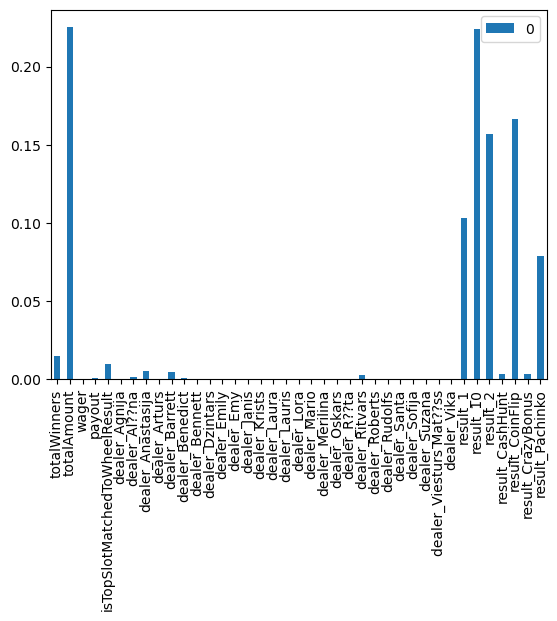

In [142]:
feature_importance.plot(kind='bar')

### Ploting the decision tree

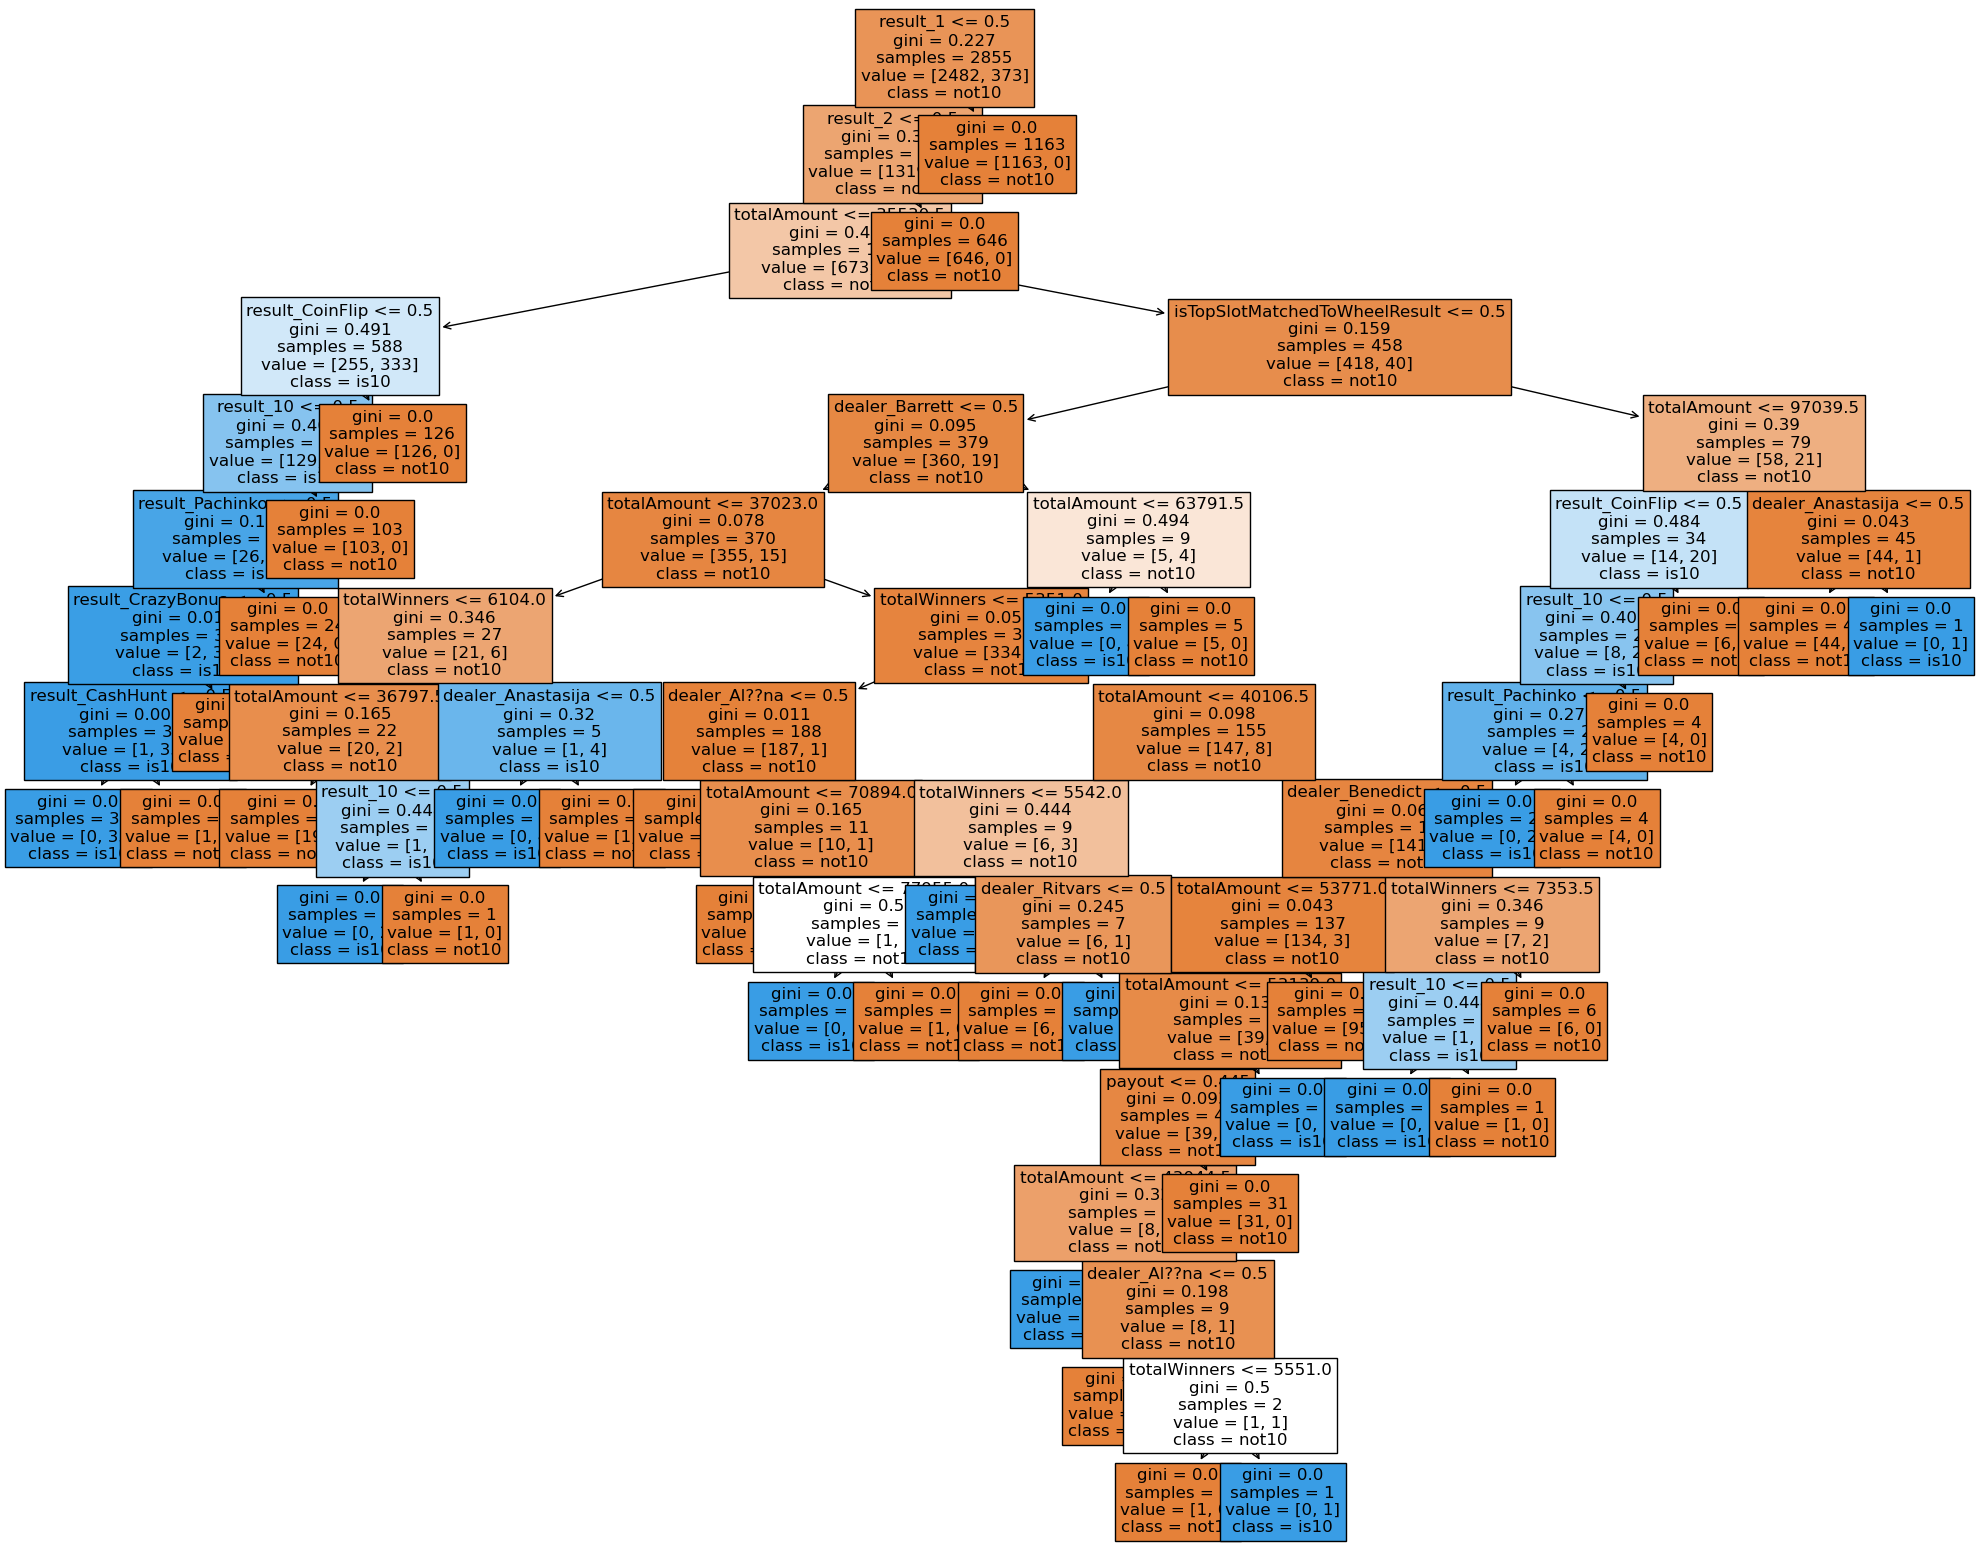

In [143]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names=feature_names,
                   class_names={0: "not10", 1:"is10"},
                   filled=True,
                   fontsize=12)